# Uses LSTM - CNN on the data set

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.losses import MeanSquaredError
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

2021-12-20 12:07:00.385975: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
data = pd.read_csv("merged_new.csv")
data['local_15min'] = pd.to_datetime(data['local_15min'])
data.drop(['leg1v', 'leg2v', 'summary', 'grid'], axis = 1, inplace = True)
train_dates = data['local_15min']

df_for = data[['solar', 'temperature', 'cloud_cover']].astype(float)
for a in range(len(df_for)):
    if df_for['solar'][a] < 0:
        df_for['solar'][a] = 0
# one month as testing set
df_for_training = df_for[:-720]
df_for_testing = df_for[8240:]

# one week as testing set
#df_for_training = df_for[:-168]
#df_for_testing = df_for[8792:]

,solar,temperature,cloud_cover
8953,0.0,40.49,1.0
8954,0.0,40.33,1.0
8955,0.0,40.49,1.0
8956,0.0,40.80,1.0
8957,0.0,41.27,1.0


In [9]:
# scaler transformation
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

df_for_testing_scaled = scaler.transform(df_for_testing)

In [38]:
def slice(df):
    trainX = []
    trainY = []

    n_future = 1   
    n_past = 24 

    for i in range(n_past, len(df) - n_future +1):
        trainX.append(df[i - n_past:i, 0:df.shape[1]])
        trainY.append(df[i + n_future - 1:i + n_future, 0])

    return np.array(trainX), np.array(trainY)



In [39]:

#for i in range(n_past, len(df_for_training_scaled) - n_future +1):
#    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
 #   trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

#trainX, trainY = np.array(trainX), np.array(trainY)
trainX, trainY = slice(df_for_training_scaled)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print(trainX.shape[1])
print(trainX.shape[2])
trainY

trainX shape == (8214, 24, 3).
trainY shape == (8214, 1).
24
3


array([[-0.64603804],
       [-0.64603804],
       [-0.64603804],
       ...,
       [-0.64603804],
       [-0.64603804],
       [-0.64603804]])

In [12]:


testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))
print(trainX.shape[1])
print(trainX.shape[2])

testX shape == (694, 24, 3).
testY shape == (694, 1).
24
3


In [13]:
# define the  model

model = Sequential()
model.add(LSTM(128, activation = 'relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 128)           67584     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 117,057
Trainable params: 117,057
Non-trainable params: 0
_________________________________________________________________


2021-12-20 12:09:32.683872: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-20 12:09:32.685685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-20 12:09:32.760304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-20 12:09:32.760357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-20 12:09:32.762333: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-20 12:09:32.762425: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Epoch 1/20


2021-12-20 12:09:33.476709: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-20 12:09:33.477136: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


  1/462 [..............................] - ETA: 7:21 - loss: 1.1710

2021-12-20 12:09:34.245192: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


462/462 [==============================] - 13s 27ms/step - loss: 0.4333 - val_loss: 0.1349
Epoch 2/20
462/462 [==============================] - 12s 27ms/step - loss: 0.1440 - val_loss: 0.1033
Epoch 3/20
462/462 [==============================] - 13s 27ms/step - loss: 0.1258 - val_loss: 0.0952
Epoch 4/20
462/462 [==============================] - 12s 27ms/step - loss: 0.1215 - val_loss: 0.0947
Epoch 5/20
462/462 [==============================] - 13s 27ms/step - loss: 0.1175 - val_loss: 0.0864
Epoch 6/20
462/462 [==============================] - 13s 27ms/step - loss: 0.1095 - val_loss: 0.0908
Epoch 7/20
462/462 [==============================] - 13s 27ms/step - loss: 0.1053 - val_loss: 0.0954
Epoch 8/20
462/462 [==============================] - 13s 27ms/step - loss: 0.1110 - val_loss: 0.0857
Epoch 9/20
462/462 [==============================] - 13s 27ms/step - loss: 0.1006 - val_loss: 0.0805
Epoch 10/20
462/462 [==============================] - 12s 26ms/step - loss: 0.0951 - val_los

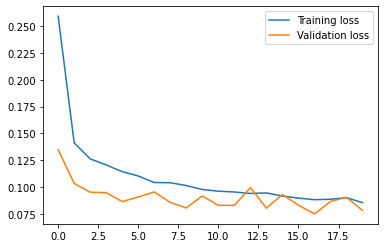

In [14]:
history = model.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [10]:
trainX[200:].shape

(8014, 24, 3)

In [11]:

#Make prediction
prediction = model.predict(testX) 

prediction.shape

(694, 1)

In [12]:

prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
pre_inverse = scaler.inverse_transform(prediction_copies)[:,0]

test_copies = np.repeat(testY, df_for_training.shape[1], axis=-1)
test_inverse = scaler.inverse_transform(test_copies)[:,0]

In [13]:
test_inverse.shape

(694,)

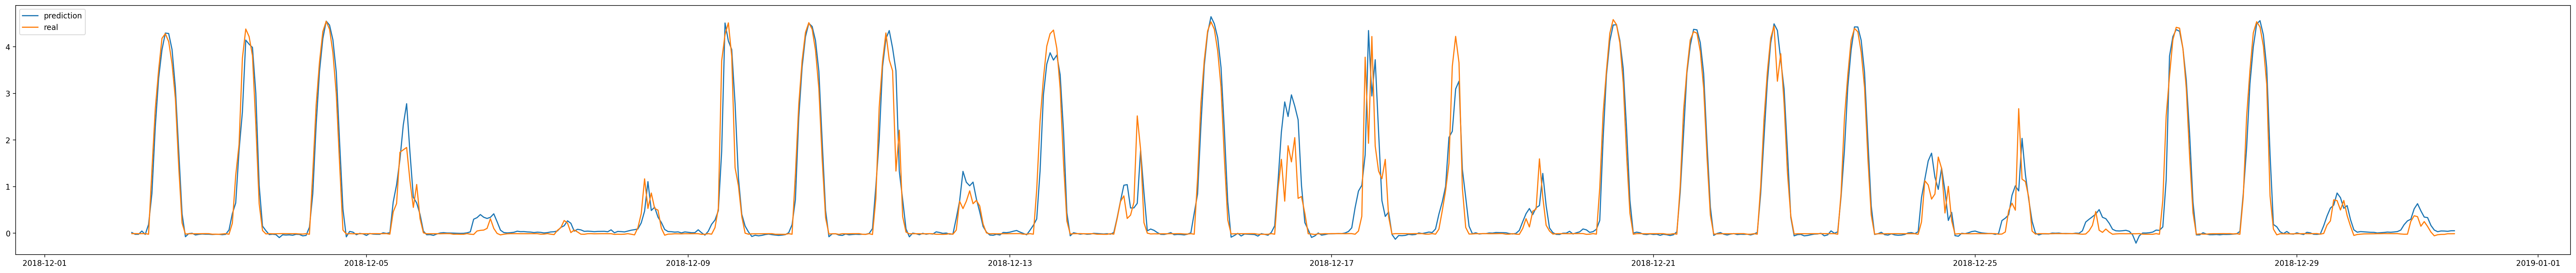

In [14]:



from matplotlib.pyplot import figure
figure(figsize=(60, 6), dpi=200)
# for one month
timestamp = train_dates[8264:]
# for one week
#timestamp = train_dates[8816:]
plt.plot(timestamp, pre_inverse)
plt.plot(timestamp, test_inverse)

plt.legend(['prediction', 'real'], loc='upper left')
plt.show()

In [15]:
mse = MeanSquaredError()
mse(pre_inverse, test_inverse).numpy()

0.12438131868839264

In [16]:
pre_inverse.shape

(694,)

In [17]:
test_inverse.shape

(694,)

In [18]:
(pre_inverse-test_inverse).max()

2.419214553833008

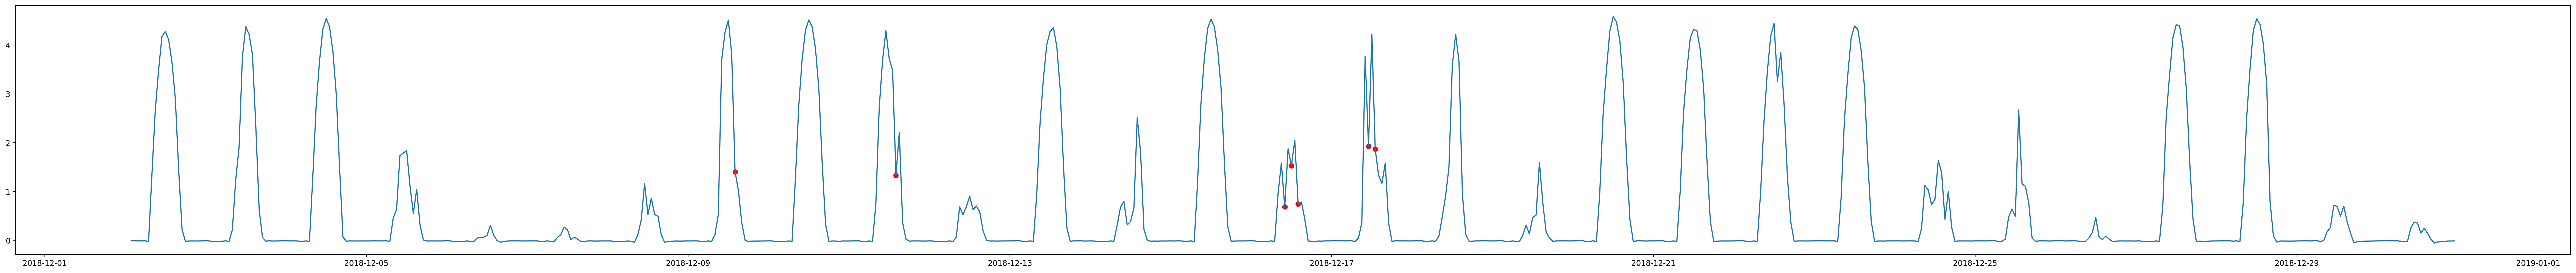

In [19]:
from matplotlib.pyplot import figure
figure(figsize=(60, 6), dpi=200)

plt.plot(train_dates[8264:], test_inverse)

MAE = np.mean(np.abs(test_inverse - pre_inverse), axis=0)
diff = pre_inverse-test_inverse
thor = diff.mean() + diff.std()*3
MAE_df = pd.DataFrame(
    {'data': train_dates[8264:],
     'MAE': pre_inverse-test_inverse,
     'ori': test_inverse
    })

MAE_df = MAE_df.loc[MAE_df['MAE'] > thor]

plt.scatter(MAE_df['data'], MAE_df['ori'], c = 'red')

In [20]:
MAE_df

,data,MAE,ori
8444,2018-12-09 14:00:00,1.372680,1.406
8492,2018-12-11 14:00:00,2.154055,1.334
8608,2018-12-16 10:00:00,2.129152,0.688
8610,2018-12-16 12:00:00,1.438077,1.531
8612,2018-12-16 14:00:00,1.685252,0.748
8633,2018-12-17 11:00:00,2.419215,1.930
8635,2018-12-17 13:00:00,1.853130,1.870


In [21]:
MAE

0.16912346898091513

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.33087653, -0.2975432 , -0.26420986, -0.23087653, -0.1975432 ,
        -0.16420986, -0.13087653, -0.0975432 , -0.06420986, -0.03087653,
         0.0024568 ,  0.03579014,  0.06912347,  0.1024568 ,  0.13579014,
         0.16912347,  0.2024568 ,  0.23579014,  0.26912347,  0.3024568 ,
         0.33579014,  0.36912347,  0.4024568 ,  0.43579014,  0.46912347,
         0.5024568 ,  0.53579014,  0.56912347,  0.6024568 ,  0.63579014,
         0.66912347]),
 <BarContainer object of 30 artists>)

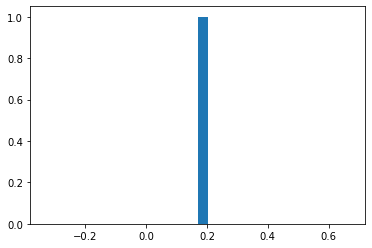

In [22]:
plt.hist(MAE, bins=30)